In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# models for regression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold

In [2]:
data_path = 'csv_data/'
data_folders = ['NR', 'ER', 'public_test', 'private_test']

df_NR = pd.read_csv(data_path + 'df_' + data_folders[0] +'.csv', index_col='Unnamed: 0')
df_ER = pd.read_csv(data_path + 'df_' + data_folders[1] +'.csv', index_col='Unnamed: 0')
df_public_test = pd.read_csv(data_path + 'df_' + data_folders[2] +'.csv', index_col='Unnamed: 0')
df_private_test = pd.read_csv(data_path + 'df_' + data_folders[3] +'.csv', index_col='Unnamed: 0')

In [60]:
df_NR.columns

Index(['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
       'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
       'dsigma', 'edm_x', 'edm_y', 'event_ID', 'event_angle', 'event_class',
       'event_energy', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
       'fval_y', 'has_accurate_covar_x', 'has_accurate_covar_y',
       'has_covariance_x', 'has_covariance_y', 'has_made_posdef_covar_x',
       'has_made_posdef_covar_y', 'has_parameters_at_limit_x',
       'has_parameters_at_limit_y', 'has_posdef_covar_x', 'has_posdef_covar_y',
       'has_reached_call_limit_x', 'has_reached_call_limit_y',
       'has_valid_parameters_x', 'has_valid_parameters_y', 'hesse_failed_x',
       'hesse_failed_y', 'image_name', 'is_above_max_edm_x',
       'is_above_max_edm_y', 'is_valid_x', 'is_valid_y', 'mu_error_x',
       'mu_error_y', 'mu_x', 'mu_y', 'n_excess_bins_x', 'n_excess_bins_y',
       'nfcn_total_x', 'nfcn_total_y', 'nfcn_x', 'nfcn_y', 'ngr

In [210]:
# cols = np.append(np.array(range(15)), np.array(range(19, 24)))
# corr_NR = [np.corrcoef(df_NR[df_NR.columns[i]].values, df_NR['event_energy'].values)[0][1] for i in cols]
# corr_ER = [np.corrcoef(df_ER[df_ER.columns[i]].values, df_ER['event_energy'].values)[0][1] for i in cols]

In [66]:
feat_list = ['N_error_x', 'N_error_y', 'N_x', 'N_y', 'bkgr_count_x', 'bkgr_count_y',
       'chi2_pvalue_x', 'chi2_pvalue_y', 'chi2_x', 'chi2_y', 'dfr', 'dmu',
       'dsigma', 'edm_x', 'edm_y', 'fr_error_x', 'fr_error_y', 'fr_x', 'fr_y', 'fval_x',
       'fval_y']
# NR_label = 0
# ER_label = 1

In [251]:
df_train = df_NR[feat_list]
df_train = df_train.append(df_ER[feat_list], ignore_index=True)

corr_th = 0.15

corr_reg = [np.corrcoef(df_train[df_train.columns[i]].values, y_train_energies)[0][1] for i in range(21)]
reg_col = np.array(df_train.columns[np.argwhere(np.abs(corr_reg) > corr_th)])
reg_cols = [reg_col[i][0] for i in range(len(reg_col))]
df_train_reg = df_train[reg_cols]

corr_cl = [np.corrcoef(df_train[df_train.columns[i]].values, y_train_classes)[0][1] for i in range(21)] 
cl_col = np.array(df_train.columns[np.argwhere(np.abs(corr_cl) > corr_th)])
cl_cols = [cl_col[i][0] for i in range(len(cl_col))]
df_train_cl = df_train[cl_cols]

y_train_energies = np.append(np.array(df_NR['event_energy'].values), np.array(df_ER['event_energy'].values))
y_train_classes = np.array([i>len(df_NR) for i in range(len(df_NR) + len(df_ER))], dtype=np.int)

In [252]:
df_test = df_public_test[feat_list]
df_test = df_test.append(df_private_test[feat_list], ignore_index=True)

df_test_reg = df_test[reg_cols]
df_test_cl = df_test[cl_cols]

## regression

#### comparing various models with default parameters:

In [370]:
models = {'Ridge': linear_model.Ridge(),
          'RidgeStS': make_pipeline(StandardScaler(), linear_model.Ridge()),
          'kNN': neighbors.KNeighborsRegressor(weights='uniform'), 
          'BayesianRidge': linear_model.BayesianRidge(),
          'DT' : tree.DecisionTreeRegressor(criterion="mse"), # mae worked too long
          'RFT' : RandomForestRegressor(criterion="mse"),
          'SVR': svm.SVR(),
          'MLPRegressor': MLPRegressor(),
          'AdaBoost': AdaBoostRegressor()
         }

##### train on many features

In [371]:
for model_name, model in models.items():
    sc = cross_validate(model, df_train.values, y_train_energies, scoring='neg_mean_absolute_error', cv=5)
    print(model_name + ' feat-s : {:.2f} +- {:.2f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.26817e-18): result may not be accurate.
  overwrite_a=True).T
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.28559e-18): result may not be accurate.
  overwrite_a=True).T
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.29237e-18): result may not be accurate.
  overwrite_a=True).T
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.24551e-18): result may not be accurate.
  overwrite_a=True).T


Ridge feat-s : -772.20 +- 1530.58
RidgeStS feat-s : -759.43 +- 1505.07
kNN feat-s : -0.65 +- 0.05
BayesianRidge feat-s : -766.32 +- 1518.83
DT feat-s : -0.29 +- 0.07
RFT feat-s : -0.33 +- 0.05
SVR feat-s : -8.77 +- 1.31
MLPRegressor feat-s : -39531.38 +- 58409.39
AdaBoost feat-s : -1.95 +- 0.54


##### train on the selected subset of features:

In [372]:
for model_name, model in models.items():
    sc = cross_validate(model, df_train_reg.values, y_train_energies, scoring='neg_mean_absolute_error', cv=5)
    print(model_name + ' feat-s : {:.2f} +- {:.2f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

Ridge feat-s : -7.38 +- 0.29
RidgeStS feat-s : -7.38 +- 0.29
kNN feat-s : -6.54 +- 0.84
BayesianRidge feat-s : -7.38 +- 0.29
DT feat-s : -5.70 +- 1.03
RFT feat-s : -4.77 +- 1.44
SVR feat-s : -8.76 +- 1.24
MLPRegressor feat-s : -91.71 +- 54.96
AdaBoost feat-s : -5.88 +- 1.60


#### GridSearch optimal parameters:

In [333]:
parameters = {'alpha': np.logspace(-4, 3, num=9)}
model = linear_model.Ridge()
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train_reg.values, y_train_energies)
print(reg.best_estimator_)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [373]:
parameters = {'n_neighbors': [1,2,5,10,30,50,100]}
model = neighbors.KNeighborsRegressor(weights='uniform')
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train.values, y_train_energies)
print(reg.best_estimator_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')


In [374]:
parameters = {}
model = linear_model.BayesianRidge()
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train_reg.values, y_train_energies)
print(reg.best_estimator_)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


In [375]:
parameters = {'max_depth': [None, 1, 2, 3, 4, 5, 10, 50]}
model = tree.DecisionTreeRegressor(criterion="mse")
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train.values, y_train_energies)
print(reg.best_estimator_)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


In [376]:
parameters = {'max_depth': [None, 1, 5, 10], 'n_estimators': [1, 50, 100]}
model = RandomForestRegressor(criterion="mse")
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train.values, y_train_energies)
print(reg.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [377]:
parameters = {'C': [0.1, 1]}
model = svm.SVR()
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train.values, y_train_energies)
print(reg.best_estimator_)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [382]:
parameters = {'hidden_layer_sizes': [(100,), (10, 50, 10)]}
model = MLPRegressor()
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train_reg.values, y_train_energies)
print(reg.best_estimator_)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 50, 10), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


In [379]:
parameters = {'n_estimators': [50,100,150]}
model = AdaBoostRegressor()
reg = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error')
reg.fit(df_train.values, y_train_energies)
print(reg.best_estimator_)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)


In [385]:
models = {'RidgeStS': make_pipeline(StandardScaler(), linear_model.Ridge(alpha=1e-4)),
          'kNN': neighbors.KNeighborsRegressor(n_neighbors=1, weights='uniform'), 
          'BayesianRidge': linear_model.BayesianRidge(),
          'DT' : tree.DecisionTreeRegressor(max_depth=50, criterion="mse"), 
          'RFT' : RandomForestRegressor(max_depth=None, n_estimators=50, criterion="mse"),
          'SVR': svm.SVR(C=1.0),
          'MLPRegressor': MLPRegressor(hidden_layer_sizes=(10, 50, 10)),
          'AdaBoost': AdaBoostRegressor(n_estimators=50)
         }

In [386]:
for model_name, model in models.items():
    if model_name == 'RidgeStS' or model_name == 'BayesianRidge' or model_name == 'MLPRegressor':
        data_for_training = df_train_reg.values
    else:
        data_for_training = df_train.values
            
    sc = cross_validate(model, data_for_training, y_train_energies, scoring='neg_mean_absolute_error', cv=5)
    print(model_name + ' feat-s : {:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

RidgeStS feat-s : -7.3780 +- 0.2939
kNN feat-s : -0.5323 +- 0.0535
BayesianRidge feat-s : -7.3812 +- 0.2911
DT feat-s : -0.2965 +- 0.0674
RFT feat-s : -0.3320 +- 0.0491
SVR feat-s : -8.7659 +- 1.3069


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor feat-s : -63.3632 +- 53.4556
AdaBoost feat-s : -1.8783 +- 0.4179


#### fit and predict with the best model:

In [387]:
reg = tree.DecisionTreeRegressor(max_depth=50, criterion="mse").fit(df_train.values, y_train_energies)
reg_pred = reg.predict(df_test.values)

In [392]:
reg_pred[reg_pred < 1] = 1
reg_pred[reg_pred > 30] = 30

(array([6063., 2165.,    0., 3052.,    0.,    0.,  848.,    0.,    0.,
        4435.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

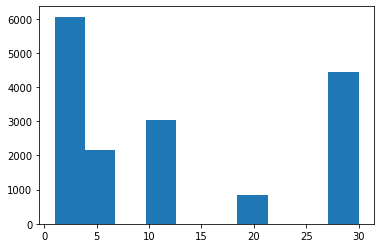

In [393]:
plt.hist(reg_pred)

## classification

##### compare models with default parameters:

In [335]:
models = {'LogResStS': make_pipeline(StandardScaler(), LogisticRegression()),
          'LDA': LinearDiscriminantAnalysis(), 
          'DT': DecisionTreeClassifier(),
          'RandomFC' : RandomForestClassifier(), 
          'SVM' : svm.SVC(),
          'MLPStS': make_pipeline(StandardScaler(), MLPClassifier()),
          'kNNN': KNeighborsClassifier(),
          'AdaBoostSts': make_pipeline(StandardScaler(), AdaBoostClassifier())
         }

##### train on many features:

In [337]:
for model_name, model in models.items():
    sc = cross_validate(model, df_train.values, y_train_classes, scoring='roc_auc', cv=5)
    print(model_name + ' feat-s : {:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

LogResStS feat-s : 0.6876 +- 0.0123
LDA feat-s : 0.6641 +- 0.0094
DT feat-s : 0.9416 +- 0.0075
RandomFC feat-s : 0.9943 +- 0.0010
SVM feat-s : 0.6665 +- 0.0089


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) re

MLPStS feat-s : 0.9469 +- 0.0028


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer


kNNN feat-s : 0.9554 +- 0.0038
AdaBoostSts feat-s : 0.9896 +- 0.0019


##### train on the selected subset of features:

In [338]:
for model_name, model in models.items():
    sc = cross_validate(model, df_train_cl.values, y_train_classes, scoring='roc_auc', cv=5)
    print(model_name + ' feat-s : {:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

LogResStS feat-s : 0.6674 +- 0.0124
LDA feat-s : 0.6434 +- 0.0095
DT feat-s : 0.5940 +- 0.0034
RandomFC feat-s : 0.6649 +- 0.0144
SVM feat-s : 0.6675 +- 0.0134
MLPStS feat-s : 0.6679 +- 0.0129
kNNN feat-s : 0.6591 +- 0.0112


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer


AdaBoostSts feat-s : 0.6651 +- 0.0111


##### GridSearch parameters:

In [341]:
parameters = {'C': np.logspace(-5, 3, num=9), 'max_iter': [1000,10000]}
model =  LogisticRegression()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [342]:
parameters = {}
model =  LinearDiscriminantAnalysis()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [343]:
parameters = {'max_depth': [None, 1, 2, 3, 4, 5, 10, 50]}
model =  DecisionTreeClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [344]:
parameters = {'max_depth': [None, 1, 5, 10], 'n_estimators': [1, 5, 10, 50, 100]}
model =  RandomForestClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [345]:
parameters = {'kernel':['rbf'], 'C':[1e-1, 1]}
model =  svm.SVC()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [346]:
parameters = {'hidden_layer_sizes': [(100,), (10, 50, 10)]}
model =  MLPClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) re

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 50, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [347]:
parameters = {'n_neighbors': [1,2,5,10,50,100]}
model = KNeighborsClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer


In [356]:
#parameters = {'learning_rate': np.logspace(-1, 2, num=4), 'n_estimators': [100, 150]}
parameters = {'n_estimators': [100, 150]}
model =  AdaBoostClassifier()
clf = GridSearchCV(model, parameters, scoring='roc_auc')
clf.fit(df_train.values, y_train_classes)
print(clf.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=150, random_state=None)


In [359]:
models = {'LogRes': LogisticRegression(C=1e-4, max_iter=1000),
          'LDA': LinearDiscriminantAnalysis(), 
          'DT': DecisionTreeClassifier(max_depth=10),
          'RandomFC' : RandomForestClassifier(max_depth=None, n_estimators=100), 
          'SVM' : svm.SVC(kernel='rbf', C=1.0),
          'MLPStS': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(10, 50, 10))),
          'kNNN': KNeighborsClassifier(n_neighbors=50),
          'AdaBoost': AdaBoostClassifier(n_estimators=150)
         }

In [360]:
for model_name, model in models.items():
    sc = cross_validate(model, df_train.values, y_train_classes, scoring='roc_auc', cv=5)
    print(model_name + ' feat-s : {:.4f} +- {:.4f}'.format(np.mean(sc['test_score']), np.std(sc['test_score'])))

LogRes feat-s : 0.6531 +- 0.0045
LDA feat-s : 0.6641 +- 0.0094
DT feat-s : 0.9778 +- 0.0058
RandomFC feat-s : 0.9945 +- 0.0010
SVM feat-s : 0.6665 +- 0.0089


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPStS feat-s : 0.9862 +- 0.0013


/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer
/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:244: RuntimeWarning: invalid value encountered in true_divide
  proba_k /= normalizer


kNNN feat-s : 0.9656 +- 0.0030
AdaBoost feat-s : 0.9903 +- 0.0015


#### fit and predict with the best model:

In [398]:
log_res = RandomForestClassifier(max_depth=None, n_estimators=100).fit(df_train.values, y_train_classes)
cl_pred = log_res.predict(df_test.values)

In [400]:
im_names = np.append(df_public_test['image_name'].values, df_private_test['image_name'].values)

# np.random.seed(10)
# reg_pred = 29*np.random.random_sample(size=16563) + 1
# cl_pred = np.random.randint(2, size=16563)

In [401]:
def generate_submission(cl_pred, reg_pred, im_names, submission_name):
    
    sample_submission = pd.read_csv(data_path + 'track1_predictions_example.csv')
    
    # create dataframe
    submission = pd.DataFrame(columns=sample_submission.columns)
    submission['id'] = im_names
    submission['classification_predictions'] = cl_pred
    submission['regression_predictions'] = reg_pred

    # add an entry that was exluded from the private test dataset by the 'try-except' method
    submission = submission.append(submission.iloc[len(submission)-1], ignore_index=True)
    submission['id'].iloc[len(submission)-1]  = '057f420d13253901195b932f1c9e933361e362d3'
    submission['classification_predictions'].iloc[len(submission)-1]  = 1 #ER
    submission['regression_predictions'].iloc[len(submission)-1]  = 1

    # sort values by id
    idx = submission.index
    submission.sort_values('id', inplace=True)
    submission.index = idx
    
    # save to csv
    submission.to_csv(submission_name + '.csv', index=False, header=True)

In [402]:
generate_submission(cl_pred, reg_pred, im_names, 'DT_50_reg_RFT_100_cl')

/trinity/shared/opt/python-3.6.8/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [77]:
# energies = [1,3,6,10,20,30]
# NR_train_energies = [1,6,20]
# ER_train_energies = [3,10,30]
# value_NR = [np.median(df_NR[df_NR['event_energy'] == e]['dmu']) for e in NR_train_energies]
# value_ER = [np.median(df_ER[df_ER['event_energy'] == e]['dmu']) for e in ER_train_energies]
# std_NR = [np.std(df_NR[df_NR['event_energy'] == e]['dmu']) for e in NR_train_energies]
# std_ER = [np.std(df_ER[df_ER['event_energy'] == e]['dmu']) for e in ER_train_energies]
# #plt.hist(df_ER[df_ER['event_energy'] == 30]['N_x'])

In [92]:
# plt.bar(x=NR_train_energies, height=value_NR, align='center', alpha=0.5)
# plt.ylim((-, 1))